In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage import data
from skimage.restoration import wiener, richardson_lucy, denoise_tv_chambolle
from utilities import *

# Deconvolution with $\ell_1$ regularisation

In general, we want to solve

$$\min_{u} \frac{1}{2}\|Ku - f^\delta\|_2^2 + \alpha \|Ru\|_1.$$

* The corresponding denoising problem is central to solving the deconvolution problem

# Proximal gradient - the recipe

Solve 
$$\min_u F(u) + G(u),$$

by iterating

$$v_{k+1} = u_k - \lambda \nabla F(u_k),$$
$$u_{k+1} = \text{arg}\min_u \textstyle{\frac{1}{2}}\|u - v_{k+1}\|_2^2 + \alpha \|Ru\|_1$$

In [16]:
def TV_decon(f, psf, alpha, lmbda, maxit = 100, tol=1e-3):
    """
    TV deconvolution, solves: 
        
        min_u 0.5\|Ku - f\|_2^2 + \alpha TV(u)
    
    using a proximal gradient method.
    
    input:
        f     - data, 2D array
        psf   - psf to define forward operator K, 2D array
        alpha - regularisation parameter, float
        lmbda - stepsize for proximal gradient method, float
        maxit - max. iteration count (default 100), integer
        tol   - stopping tolerance (default 1e-3), float
    
    output:
        u    - result, 2D array
        hist - convergence history \|u_{k} - u_{k-1}\|, 1D array
    """
    u = np.zeros(f.shape)
    converged = False
    hist = []
    it = 0
    while not converged:
        r = K(u,psf,mode='forward') - f
        v = u - lmbda*K(r,psf,mode='adjoint')
        up = denoise_tv_chambolle(v, weight = alpha, eps=1e-6, n_iter_max=5000)
        
        du = np.linalg.norm(u - up)
        it += 1
        
        converged = (du <= tol) or (it >= maxit)
        hist.append(du)
        u = up
    return u, np.array(hist)

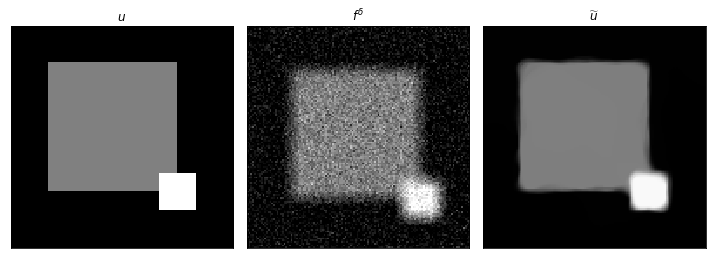

In [31]:
# make image
n = 128
u = squares_image(n)

# apply forward operator
psf = np.ones((10, 10)) / 100
f = K(u,psf)

# add_noise
delta = 1e-1
f_delta = f + delta * np.random.randn(n,n)

# reconstruct
alpha = 1e-2
lmbda = .1
maxit = 200
u_est, hist = TV_decon(f_delta, psf, alpha, lmbda, maxit)

# plot
plot_images([u, f_delta,u_est], [r'$u$', r'$f^\delta$',r'$\widetilde{u}$'])

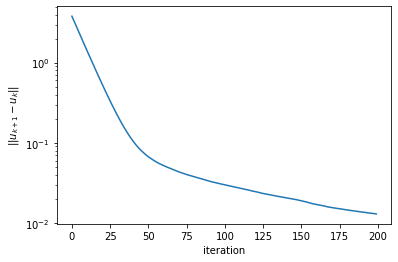

In [37]:
plt.semilogy(hist)
plt.xlabel('iteration')
plt.ylabel('$||u_{k+1} - u_k||$')
plt.show()

# Proximal gradient - why does it work?

* Smooth optimisation
* Gradient descent
* Proximal operators?

Solve

$$\min_{u} F(u) + G(u),$$

with $F$ and $G$ smooth.

* A minimiser $u_*$ satisfies the *optimality conditions* $$\nabla F(u_*) + \nabla G(u_*) = 0.$$
* The solution is thus given by $$u_* = \left(\nabla F + \nabla G\right)^{-1}(0).$$

The *gradient-descent* method finds a minimiser by re-writing this as

$$u_* - \lambda \left(\nabla F(u_*) + \nabla G(u_*)\right) = u_*$$

and employing a *fixed point* iteration
$$u_{k+1} = u_k - \lambda \left(\nabla F(u_*) + \nabla G(u_*)\right).$$

The *proximal-gradient* method uses an alternative form

$$\left(I + \lambda \nabla G\right)^{-1}\left(u_* - \lambda F(u_*)\right) = u_*,$$

and iterates

$$u_{k+1} = \left(I + \lambda \nabla G\right)^{-1}\left(u_k - \lambda F(u_k)\right)$$

We call $\left(I + \lambda \nabla G\right)^{-1}$ the *proximal operator* of $\lambda G$. We can compute it through:

$$\left(I + \lambda \nabla G\right)^{-1}(v) = \text{arg}\min_u \textstyle{\frac{1}{2}}\|u-v\|_2^2 + \lambda G(u).$$

Indeed, the solution to this problem satisfies

$$\left(I + \lambda G\right)(u_*) = v.$$